In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

In [44]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Chuẩn hóa về [0, 1] rồi trừ mean, chia std
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = np.array(Image.open(img_path).convert('RGB'))  # uint8, [0-255]
        mask = np.array(Image.open(mask_path).convert('L'))    # uint8, [0-255]

        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']  # float32, đã chuẩn hóa
        mask = augmented['mask'].float() / 255.0  # float32, [0-1]

        return image, mask.squeeze(0)

In [45]:
# DataLoader
train_dataset = CustomDataset('/kaggle/input/dataset-split/train/images', '/kaggle/input/dataset-split/train/masks')
val_dataset = CustomDataset('/kaggle/input/dataset-split/val/images', '/kaggle/input/dataset-split/val/masks')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [46]:
class UNetWithResNet50(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super(UNetWithResNet50, self).__init__()
        
        resnet50 = models.resnet50(pretrained=pretrained)
        
        # Encoder
        self.encoder0 = nn.Sequential(
            resnet50.conv1, resnet50.bn1, resnet50.relu, resnet50.maxpool
        )  # 64 channels
        self.encoder1 = resnet50.layer1  # 256 channels
        self.encoder2 = resnet50.layer2  # 512 channels
        self.encoder3 = resnet50.layer3  # 1024 channels
        self.encoder4 = resnet50.layer4  # 2048 channels
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        e0 = self.encoder0(x)  # [2, 64, 56, 56] nếu đầu vào là 224x224
        e1 = self.encoder1(e0) # [2, 256, 56, 56]
        e2 = self.encoder2(e1) # [2, 512, 28, 28]
        e3 = self.encoder3(e2) # [2, 1024, 14, 14]
        e4 = self.encoder4(e3) # [2, 2048, 7, 7]
        
        d4 = self.upconv4(e4)  # [2, 1024, 14, 14]
        d4 = torch.cat([d4, e3], dim=1)  # [2, 2048, 14, 14]
        d4 = self.decoder4(d4) # [2, 1024, 14, 14]
        
        d3 = self.upconv3(d4)  # [2, 512, 28, 28]
        d3 = torch.cat([d3, e2], dim=1)  # [2, 1024, 28, 28]
        d3 = self.decoder3(d3) # [2, 512, 28, 28]
        
        d2 = self.upconv2(d3)  # [2, 256, 56, 56]
        d2 = torch.cat([d2, e1], dim=1)  # [2, 512, 56, 56]
        d2 = self.decoder2(d2) # [2, 256, 56, 56]
        
        d1 = self.upconv1(d2)  # [2, 64, 112, 112]
        e0 = F.interpolate(e0, size=d1.shape[2:], mode='bilinear', align_corners=False)  # [2, 64, 112, 112]
        d1 = torch.cat([d1, e0], dim=1)  # [2, 128, 112, 112]
        d1 = self.decoder1(d1) # [2, 64, 112, 112]
        
        out = self.final_conv(d1) # [2, 1, 112, 112]
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)  # [2, 1, 224, 224]
        return out

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithResNet50(n_classes=1).to(device)

In [48]:
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

criterion = lambda pred, target: 0.5 * nn.BCEWithLogitsLoss()(pred, target) + 0.5 * dice_loss(pred, target)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

In [49]:
# Metric
def iou_metric(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum()
    union = (pred + target - pred * target).sum()
    return intersection / (union + 1e-6) if union > 0 else 0

def pixel_accuracy(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

In [50]:
# Huấn luyện
num_epochs = 50
best_iou = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_pixel_acc = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            val_loss += loss.item()
            
            for output, mask in zip(outputs, masks):
                iou = iou_metric(output.squeeze(), mask)
                val_iou += iou
                val_pixel_acc += pixel_accuracy(output.squeeze(), mask)
    
    val_loss /= len(val_loader)
    val_iou /= len(val_loader.dataset)
    val_pixel_acc /= len(val_loader.dataset)
    
    scheduler.step(val_iou)
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), '/kaggle/working/best_unet_resnet50.pth')
        print(f"Đã lưu mô hình với IoU: {best_iou:.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou*100:.2f}%, Val Pixel Acc: {val_pixel_acc*100:.2f}%")

Đã lưu mô hình với IoU: 0.3217
Epoch [1/50], Train Loss: 0.5138, Val Loss: 0.4795, Val IoU: 32.17%, Val Pixel Acc: 65.42%
Đã lưu mô hình với IoU: 0.3509
Epoch [2/50], Train Loss: 0.4579, Val Loss: 0.4455, Val IoU: 35.09%, Val Pixel Acc: 66.26%
Đã lưu mô hình với IoU: 0.3847
Epoch [3/50], Train Loss: 0.4263, Val Loss: 0.4246, Val IoU: 38.47%, Val Pixel Acc: 65.50%
Đã lưu mô hình với IoU: 0.4130
Epoch [4/50], Train Loss: 0.4059, Val Loss: 0.4078, Val IoU: 41.30%, Val Pixel Acc: 66.41%
Đã lưu mô hình với IoU: 0.4234
Epoch [5/50], Train Loss: 0.3979, Val Loss: 0.3881, Val IoU: 42.34%, Val Pixel Acc: 67.86%
Đã lưu mô hình với IoU: 0.4378
Epoch [6/50], Train Loss: 0.3863, Val Loss: 0.3717, Val IoU: 43.78%, Val Pixel Acc: 68.45%
Epoch [7/50], Train Loss: 0.3825, Val Loss: 0.4689, Val IoU: 18.03%, Val Pixel Acc: 69.56%
Epoch [8/50], Train Loss: 0.3769, Val Loss: 0.3871, Val IoU: 41.34%, Val Pixel Acc: 67.73%
Epoch [9/50], Train Loss: 0.3710, Val Loss: 0.3688, Val IoU: 43.00%, Val Pixel Acc: 68

In [51]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Giả sử bạn đã định nghĩa UNetWithResNet50 và CustomDataset như trước
# Định nghĩa lại các hàm metric
def iou_metric(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    intersection = (pred * target).sum()
    union = (pred + target - pred * target).sum()
    return intersection / (union + 1e-6) if union > 0 else 0

def pixel_accuracy(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

# Tạo DataLoader cho tập test
test_dataset = CustomDataset('/kaggle/input/dataset-split/test/images', '/kaggle/input/dataset-split/test/masks')
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Khởi tạo mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithResNet50(n_classes=1).to(device)

# Tải mô hình tốt nhất
model.load_state_dict(torch.load('/kaggle/working/best_unet_resnet50.pth'))
model.eval()

# Đánh giá trên tập test
test_iou = 0.0
test_pixel_acc = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        for output, mask in zip(outputs, masks):
            iou = iou_metric(output.squeeze(), mask)
            test_iou += iou
            test_pixel_acc += pixel_accuracy(output.squeeze(), mask)

# Tính trung bình trên toàn bộ tập test
test_iou /= len(test_loader.dataset)
test_pixel_acc /= len(test_loader.dataset)

print(f"Test IoU: {test_iou*100:.2f}%")
print(f"Test Pixel Accuracy: {test_pixel_acc*100:.2f}%")

<ipython-input-51-1e83519694ba>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_unet_resnet50.pth'))


Test IoU: 44.22%
Test Pixel Accuracy: 69.11%


<ipython-input-53-27cdc6d72722>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_unet_resnet50.pth'))


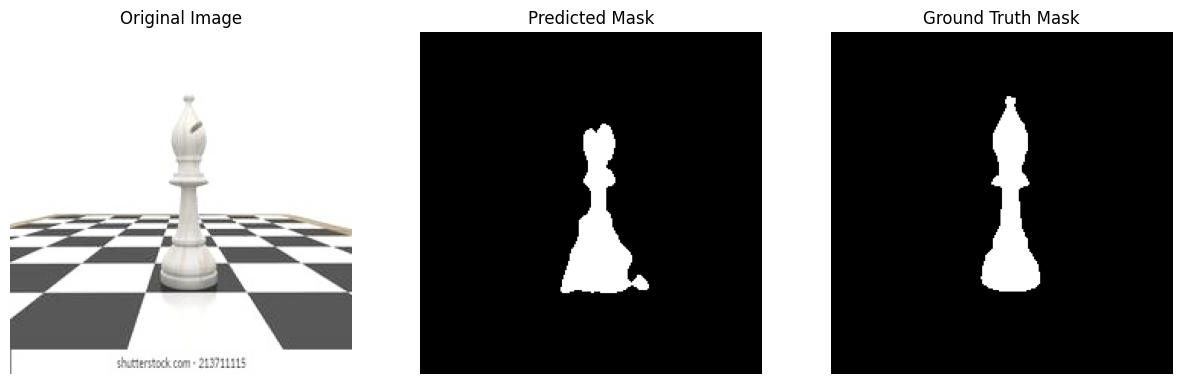

In [53]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Hàm dự đoán và hiển thị
def predict_and_visualize(model, image_path, mask_path=None, device='cuda'):
    # Transform cho ảnh đầu vào
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    # Load ảnh
    image = np.array(Image.open(image_path).convert('RGB'))
    if mask_path:
        mask_true = np.array(Image.open(mask_path).convert('L'))
    else:
        mask_true = None
    
    # Áp dụng transform
    augmented = transform(image=image)
    image_tensor = augmented['image'].unsqueeze(0).to(device)  # Thêm chiều batch
    
    # Dự đoán
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # [H, W]
        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255      # Nhị phân hóa
    
    # Hiển thị kết quả
    fig, axes = plt.subplots(1, 3 if mask_true is not None else 2, figsize=(15, 5))
    
    # Ảnh gốc
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Mask dự đoán
    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    
    # Mask thực tế (nếu có)
    if mask_true is not None:
        axes[2].imshow(mask_true, cmap='gray')
        axes[2].set_title("Ground Truth Mask")
        axes[2].axis('off')
    
    plt.show()

# Sử dụng hàm
model = UNetWithResNet50(n_classes=1).to(device)
model.load_state_dict(torch.load('/kaggle/working/best_unet_resnet50.pth'))

# Dự đoán cho một ảnh cụ thể
image_path = '/kaggle/input/dataset-split/test/images/brightness_normalized_bishop_112.jpg'  # Thay bằng đường dẫn thực tế
mask_path = '/kaggle/input/dataset-split/test/masks/brightness_normalized_bishop_112.png'    # Thay bằng đường dẫn thực tế (nếu có)
predict_and_visualize(model, image_path, mask_path, device=device)